In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from os.path import join
import os

from zillow.Imports.CreateDatasets import CreateDatasets

from zillow.MyPipeline.NanSubs import NanSubs
# from MyPipeline.Binner import Binner
from zillow.MyPipeline.YNto10mapper import YNto10mapper
from zillow.MyPipeline.DFtoNPArray import DFtoNPArray

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

/anaconda/envs/zillow/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/envs/zillow/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
drivers = CreateDatasets(properties_file='properties_2016.csv',
                             train_file='train_2016_v2.csv')
drivers.run()

In [5]:
params = {'n_estimators': 800,
          'learning_rate': 0.01,
          'max_depth': 6,
          'min_samples_leaf': 25,
          'subsample': 0.5,
          'max_features': 0.5
          }
gbm = GradientBoostingRegressor(loss='lad', random_state=90210, **params)

pipeline = Pipeline(
    [
        ('basefeatures', NanSubs()),
        ('trxndqflag', YNto10mapper(['taxdelinquencyflag'])),
        ('numpyarray', DFtoNPArray()),
        ("gbm", gbm)
    ]
)

print('Starting pipeline')
# Option 1 - cross validation. This has an error that I haven't figured out yet.
# cross_val_score(pipeline, drivers.Xs['x_train'], drivers.y_train, cv=5, scoring='mean_absolute_error')

# Option 2 - Fit on entire training dataset
# pipeline.fit(drivers.Xs['x_train'], drivers.y_train)

# Option 3 - Holdout set
X_train, X_test, y_train, y_test = train_test_split(drivers.Xs['x_train'], drivers.y_train, random_state=8675309)
pipeline.fit(X_train, y_train)

Starting pipeline


Pipeline(steps=[('basefeatures', NanSubs()), ('trxndqflag', YNto10mapper(columnNames=None)), ('numpyarray', DFtoNPArray()), ('gbm', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='lad', max_depth=6, max_features=0.5,
             max_leaf_nodes...      presort='auto', random_state=90210, subsample=0.5, verbose=0,
             warm_start=False))])

In [6]:
pred = pipeline.predict(X_test)

# score on test data (accuracy)
mae = metrics.mean_absolute_error(y_test, pred)
orig_mae = metrics.mean_absolute_error(drivers.y_train, np.zeros(len(drivers.y_train)))

print('MAE original: %.4f' % orig_mae)
print('MAE test set: %.4f' % mae)

MAE original: 0.0684
MAE test set: 0.0439


In [15]:
import os
from os.path import join

n_estimators = len(pipeline.named_steps['gbm'].estimators_)

def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6',
                  test_color='#d7191c', alpha=1.0):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = plt.gca()

    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color,
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label,
             linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    return test_dev, ax

cwd = os.getcwd()

test_dev, ax = deviance_plot(pipeline.named_steps['gbm'], X_test, y_test)
ax.legend(loc='upper right')
plt.savefig(join(cwd, 'zillow', 'figures/deviance.png'))

ValueError: could not convert string to float: 'Y'

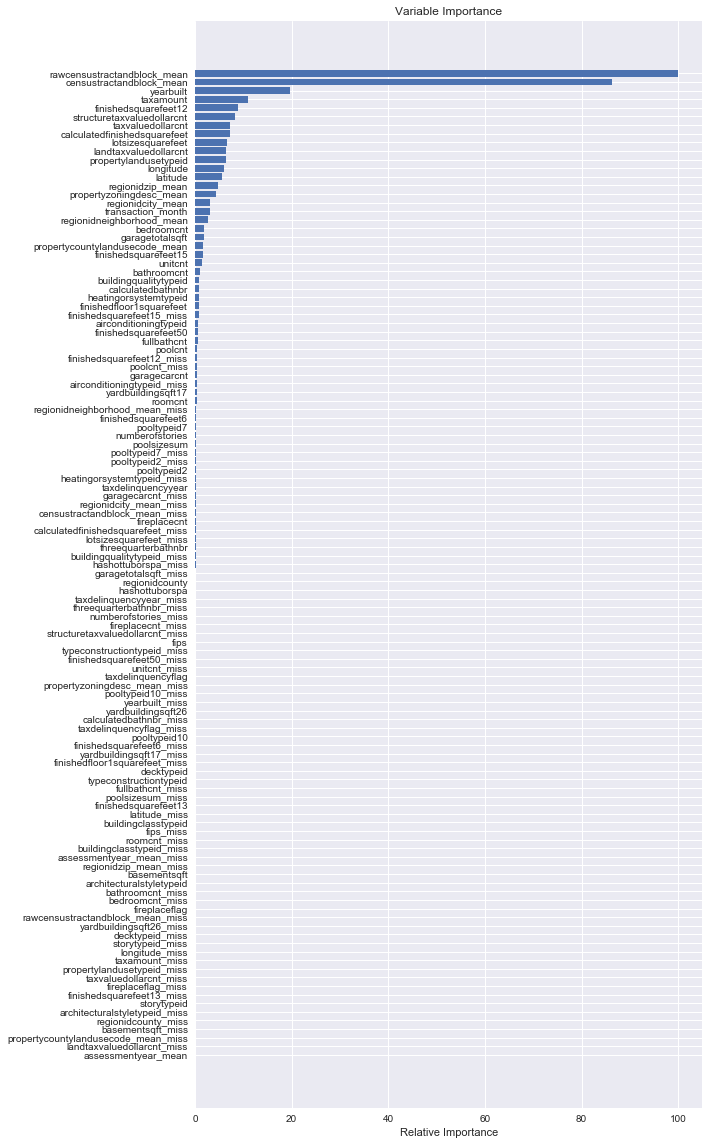

In [18]:
feature_importance = pipeline.named_steps['gbm'].feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, drivers.Xs['x_train'].columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
cwd = os.getcwd()
plt.savefig(join(cwd, 'figures/feature_importance.png'))

In [ ]:
submission_y = pipeline.predict(drivers.Xs['x_scoring'])

In [ ]:
# Append y's to driver
submission_nonpivoted = pd.DataFrame({
        "ParcelId": drivers.scoring_driver["parcelid"],
        "transactiondate": drivers.scoring_driver["transactiondate"],
        "Pred": submission_y
    })

In [ ]:
submission = submission_nonpivoted.pivot(index='ParcelId', columns='transactiondate', values='Pred').reset_index()
submission.columns = ['ParcelID', '201610', '201611', '201612', '201710', '201711', '201712']
submission.to_csv(join(cwd, 'submission.csv'), index=False)